In [1]:
# Colab cell
try:
    import google.colab
    IN_COLAB = True
    !wget -q https://raw.githubusercontent.com/Competencia-de-Climate-Change/WeatherBench/master/src/ml_training.py
    !pip install -q -U zarr
    !pip install -q -U fsspec
    !pip install -q -U gcsfs
    !pip install -q -U xarray
except:
    IN_COLAB = False

In [2]:
import xarray as xr
import fsspec

ds = xr.open_zarr(fsspec.get_mapper('gcs://weather-bench/region_zarr/'), consolidated=True)

print("Tamaño en GB:", ds.nbytes / 1e9)

Tamaño en GB: 19.324476644


# Polynomial Linear Regression for $T850$ and $T2M$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pickle

from src.ml_training import *

# from dask_ml.wrappers import ParallelPostFit

def to_pickle(obj, fn):
    try:
        with open(fn, 'wb') as f:
            pickle.dump(obj, f)
    except AttributeError:
        obj.to_pickle(fn)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    
results = 'results'
verbose = False

import os
if not os.path.exists(results):
    os.makedirs(results)

/opt/tljh/user/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data Loading

In [4]:
load_test_data

<function src.ml_training.load_test_data(var, ds=None, path=None, years=slice('2017', '2018', None))>

In [5]:
z_500 = ds.z.sel(level=500).drop('level')
t_850 = ds.t.sel(level=850).drop('level')

t2m   = ds.t2m

data = xr.merge([z_500, t_850, t2m])

data_train = data.sel(time=slice('1979', '2000'))
data_test  = data.sel(time=slice('2001', '2005'))

t_test   = load_test_data('t', ds=ds, years=slice('2001', '2005'))
t2m_test = load_test_data('t2m', ds=ds, years=slice('2001', '2005'))

test_data = xr.merge([t_test, t2m_test])

_, nlat, nlon = data_train.z.shape

nlat, nlon

Selecting from ds...


(12, 14)

In [6]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std  = data_train.isel(time=slice(0, None, 10000)).std().load()


# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test  = (data_test - data_mean)  / data_std

### Define combinations of training data

In [7]:
# Inputs and Outputs
experiments = [
    [['t'],             ['t']],
    [['z', 't'],        ['t']],
    [['z', 't', 't2m'], ['t']],
    [['t2m'],           ['t2m']],
    [['z', 't'],        ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

lead_time = 3*24 # Predict 3 days from current time
lead_time_str = '3d'

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [9]:
from src.non_linear_regression import *

In [10]:
preds  = {
    'poly_2'        : [],
    'poly_3'        : [],
    'poly_cv'        : [],
}

models = {
    'poly_2'        : [],
    'poly_3'        : [],
    'poly_cv'        : [],
}

train_mse = {
    'poly_2'        : [],
    'poly_3'        : [],
    'poly_cv'        : [],
}

test_mse = {
    'poly_2'        : [],
    'poly_3'        : [],
    'poly_cv'        : [],
}

weighted_mse = {
    'poly_2'        : [],
    'poly_3'        : [],
    'poly_cv'        : [],
}

max_grad = 30

model_args = [
    [
        NonLinearRegression,       
        'poly_2', 
        {
            'model': LinearRegression, 
            'kind': 'poly', 
            'transform_params': {'degree': 2},
            'model_params': {'n_jobs': -1}
        }
    ], 
    [
        NonLinearRegression,
        'poly_3', 
        {
            'model': LinearRegression, 
            'kind': 'poly', 
            'transform_params': {'degree': 3},
            'model_params': {'n_jobs': -1}
        }
    ], 
    [
        PolynomialRegressionCV,
        'poly_cv', 
        {
            'model': LinearRegression,  
            'degrees': range(1, max_grad + 1, max_grad//4),
            'model_params': {'n_jobs': -1}
        }
    ], 
]

## Run Experiments

In [11]:
for model in model_args:
    model_fun, model_str, extra_args = model
    
    print('Running:', model_str)
    for idx, (i, o) in enumerate(experiments):
        print(f'{idx}: Input variables = {i}; output variables = {o}')
        
        X_train, y_train, X_test, y_test, time = create_X_y_time(input_vars=i, 
                                                                 output_vars=o, 
                                                                 data=[data_train, data_test], 
                                                                 lead_time=lead_time, 
                                                                 data_subsample=5)
        
        data_needed_train = [X_train, y_train, X_test, y_test, nlat, nlon]
        
        predictions, model_res, mse_train, mse_test = train_regression(model=model_fun,
                                                                       data=data_needed_train,
                                                                       num_outputs=len(o),
                                                                       extra_args=extra_args,
                                                                       verbose=False)
        
        predictions = unnormalize_preds(preds=predictions, 
                                        output_vars=o, 
                                        valid_time=time, 
                                        lat_lon=[data_train.lat, data_train.lon],
                                        data_std=data_std, 
                                        data_mean=data_mean)

        preds[model_str].append(predictions)
        models[model_str].append(model_res)
        
        # Compute Weighted RMSE: RMSE with a weight that takes into account grid location
        r = compute_weighted_rmse(predictions, data_test).compute()
        if verbose:
            print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
        
        train_mse[model_str].append(mse_train)
        test_mse[model_str].append(mse_test)
        weighted_mse[model_str].append(r)
        
        # Save models
        preds_nc_str  = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.nc'
        model_res_str = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.pkl'
        
        predictions.to_netcdf(preds_nc_str)
        to_pickle(model_res, model_res_str)
    print('----------------------------------------------------------------------------')

Running: poly_2
0: Input variables = ['t']; output variables = ['t']
1: Input variables = ['z', 't']; output variables = ['t']
2: Input variables = ['z', 't', 't2m']; output variables = ['t']
3: Input variables = ['t2m']; output variables = ['t2m']
4: Input variables = ['z', 't']; output variables = ['t2m']
5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
----------------------------------------------------------------------------
Running: poly_3
0: Input variables = ['t']; output variables = ['t']
1: Input variables = ['z', 't']; output variables = ['t']
2: Input variables = ['z', 't', 't2m']; output variables = ['t']
3: Input variables = ['t2m']; output variables = ['t2m']
4: Input variables = ['z', 't']; output variables = ['t2m']
5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
----------------------------------------------------------------------------
Running: poly_cv
0: Input variables = ['t']; output variables = ['t']


100%|██████████| 5/5 [01:41<00:00, 24.02s/it]


Refitting best model...
1: Input variables = ['z', 't']; output variables = ['t']


100%|██████████| 5/5 [05:58<00:00, 87.18s/it]


Refitting best model...
2: Input variables = ['z', 't', 't2m']; output variables = ['t']


100%|██████████| 5/5 [14:37<00:00, 216.93s/it]


Refitting best model...
3: Input variables = ['t2m']; output variables = ['t2m']


100%|██████████| 5/5 [01:42<00:00, 24.17s/it]


Refitting best model...
4: Input variables = ['z', 't']; output variables = ['t2m']


100%|██████████| 5/5 [05:58<00:00, 87.06s/it]


Refitting best model...
5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']


100%|██████████| 5/5 [14:18<00:00, 211.25s/it]


Refitting best model...
----------------------------------------------------------------------------


In [12]:
import pandas as pd

results_df = pd.DataFrame(columns=['model', 'input', 'output',  'train_mse', 'test_mse', 'weighted_mse'])

block_rows = []
for key in models.keys():
    print(key)
    # repeat key as many time as needed to have a long df
    first_three_cols = np.hstack((np.array([key] * len(experiments)).reshape(len(experiments),1), 
                                  np.array(experiments, dtype='object')))
    block_rows.append(first_three_cols)
    
block_rows = np.array(block_rows).reshape(len(models.keys()) * len(experiments), 3) 

results_df['model'] = block_rows[:, 0]
results_df['input'] = block_rows[:, 1]
results_df['output'] = block_rows[:, 2]


train_mse_col = []
for model, ds_list in train_mse.items():
    train_mse_col += ds_list

test_mse_col = []
for model, ds_list in test_mse.items():
    test_mse_col += ds_list
    

weighted_mse_col = []
for model, ds_list in weighted_mse.items():
    print(model)
    model_metrics = []
    for ds in ds_list:
        exp_metrics = []
        for var in list(ds.variables):
            exp_metrics.append(round(float(ds[var].values), 4))

        model_metrics.append(exp_metrics)
    weighted_mse_col += model_metrics

    
print('\nNumber of rows equals number of metrics? ', results_df.shape[0] == len(train_mse_col))
print(results_df.shape[0], len(train_mse_col))


results_df['train_mse'] = train_mse_col
results_df['test_mse'] = test_mse_col

results_df['weighted_mse'] = weighted_mse_col
results_df['weighted_mse'] = results_df['weighted_mse'].apply(lambda x : x[0])
results_df

poly_2
poly_3
poly_cv
poly_2
poly_3
poly_cv

Number of rows equals number of metrics?  True
18 18


,model,input,output,train_mse,test_mse,weighted_mse
0,poly_2,[t],[t],0.108353,0.116934,280.5301
1,poly_2,"[z, t]",[t],0.096137,0.109806,280.5465
2,poly_2,"[z, t, t2m]",[t],0.090884,0.111499,280.5478
3,poly_2,[t2m],[t2m],0.040114,0.044237,287.2729
4,poly_2,"[z, t]",[t2m],0.044715,0.051663,287.3172
5,poly_2,"[z, t, t2m]",[t2m],0.034286,0.042213,287.2964
6,poly_3,[t],[t],0.106172,0.118747,280.5269
7,poly_3,"[z, t]",[t],0.092565,0.112309,280.5448
8,poly_3,"[z, t, t2m]",[t],0.086938,0.116503,280.5394
9,poly_3,[t2m],[t2m],0.039418,0.045150,287.2749


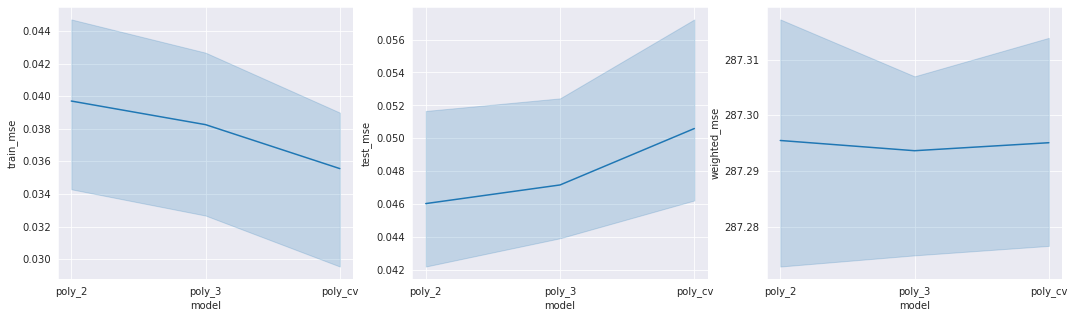

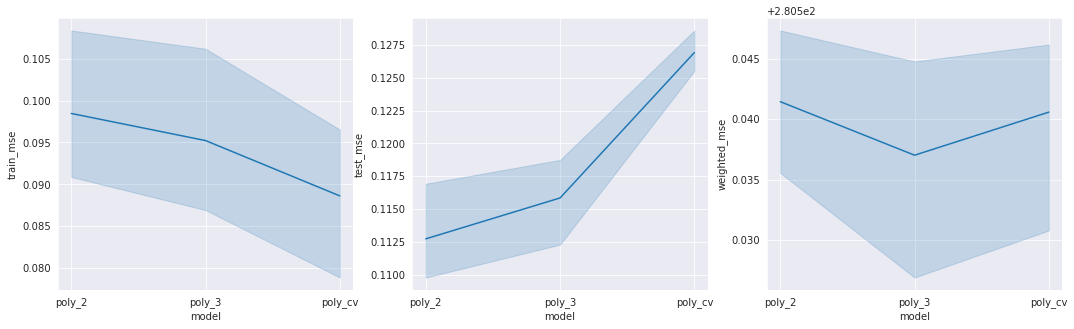

In [16]:
import seaborn as sns
sns.set_style('darkgrid')

def get_indexes(get_var):
    idxs = []
    for idx, out in results_df['output'].items():
        for var in out:
            var = str(var).lower()

            if get_var == var:
                idxs.append(idx)
    return idxs

idxs = get_indexes('t2m')
t2m_out = results_df[results_df['output'].index.isin(idxs)]

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.lineplot(data=t2m_out, x='model', y='train_mse', ax=axs[0])
sns.lineplot(data=t2m_out, x='model', y='test_mse',  ax=axs[1])
sns.lineplot(data=t2m_out, x='model', y='weighted_mse', ax=axs[2])
f.show()


idxs = get_indexes('t')
t_out = results_df[results_df['output'].index.isin(idxs)]

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.lineplot(data=t_out, x='model', y='train_mse', ax=axs[0])
sns.lineplot(data=t_out, x='model', y='test_mse',  ax=axs[1])
sns.lineplot(data=t_out, x='model', y='weighted_mse', ax=axs[2])

f.show()

